# PROJECT FOR GLOBAL AND MULTIOBJECTIVE OPTIMIZATION

## Imports and hyperparameters

In [77]:
# hyperparameters

SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100

__standard_result_flag = False
__original_hyperparameter_optimization_flag = False
__gp_run_check = False # when true we can perform the run

## Landscapes

The Landscapes class deals with fitness function used for PSO. It provides methods to translate (change minimum) and rotate the function. The considered functions are the following

In [78]:
for name in landscapes_names:
    print(name)

circle
rastrigin
schaffer
rosenbrock
easom
griewank


Let's plot the functions

In [79]:
# plotting utils
lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()

All the landscapes function have one global minimum in (0, 0). They can have multiple (or none) local minima.

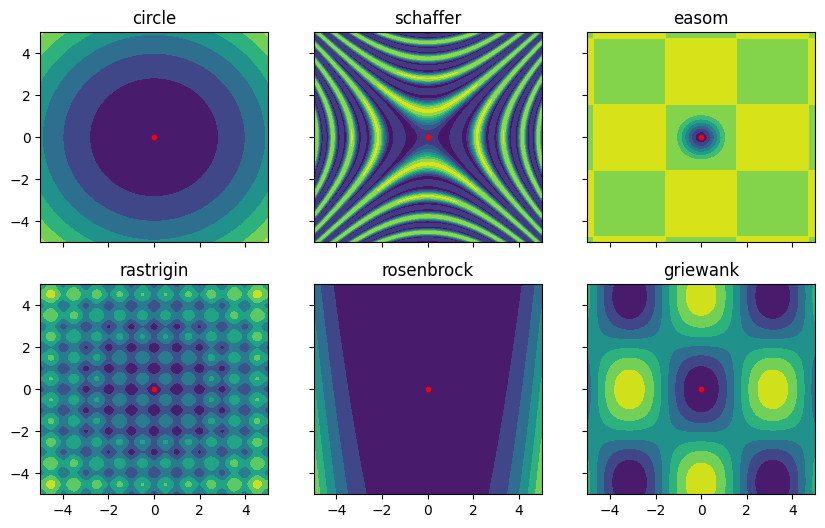

In [80]:
# plot standard landscapes

fig1, axs1 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    # landscape.rotation = rotation
    fit = landscape(pts)
    ax = axs1[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    ax.set_title(landscape.name)

To improve the generalization of PSO and GP we can translate and rotate the landscapes.

Rotation of 45°
New minimum = (1, -2)


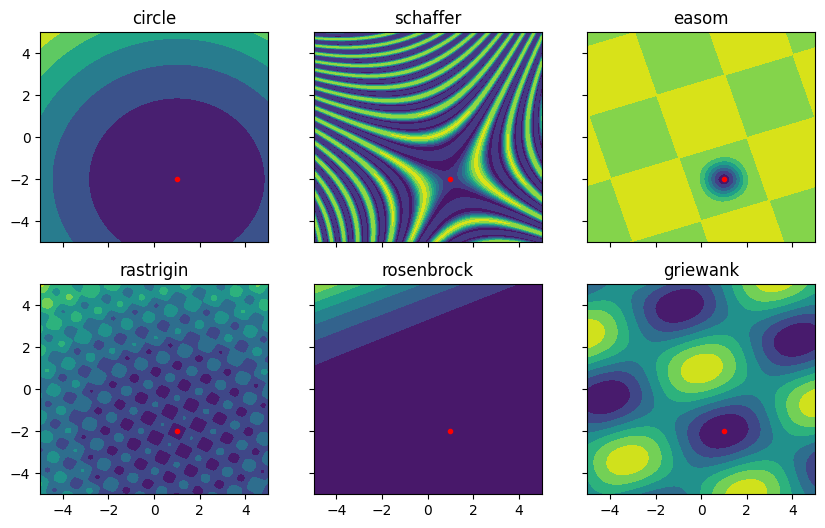

In [81]:
# plot rotated/translated landscapes

angle = 0.4 # pi/4
rotation = generate_rotation_matrix(angle*np.pi)
minimum = np.array([[1, -2]])
print(f'Rotation of 45°')
print(f'New minimum = ({minimum[0, 0]}, {minimum[0, 1]})')

fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    landscape.rotation = rotation
    landscape.minimum = minimum
    fit = landscape(pts)
    ax = axs2[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    # ax.arrow(0, 0, landscape.minimum[0, 0], landscape.minimum[0, 1], color='red')
    ax.set_title(landscape.name)

## PSO class

### Intro

Example of PSO training. The star is the function optimum, the green cross is the best position found by the swarm and the red square is the center of mass of the swarm

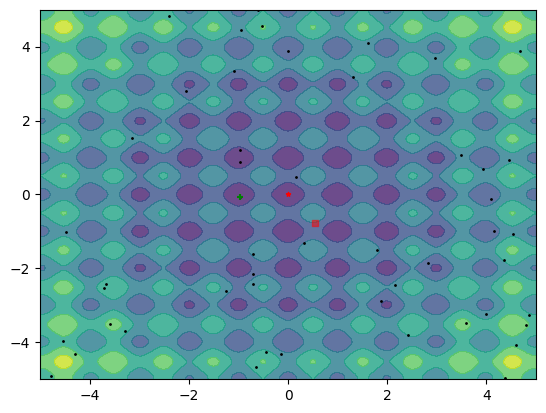

In [82]:
S = SwarmGP(50)
S.default_start(land=RASTRIGIN)
fit = RASTRIGIN(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.8)

plt.scatter(0, 0, color='red', marker='*', s=9) # -959.64066271
S.plot()

In [83]:
S.generate(200)
S.describe()

best fit value = 1.431054137412957e-06
best solution = [ 8.28077630e-05 -1.88715839e-05]
center of mass = [-0.01945991  0.16686009]
dispersion = 1.304910805411769


(-5.0, 5.0)

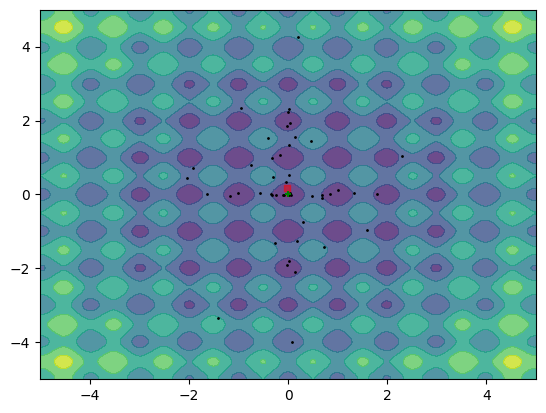

In [84]:
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.8)

plt.scatter(0, 0, color='red', marker='*', s=9) # -959.64066271
S.plot()
plt.xlim(-5, 5)
plt.ylim(-5, 5)

### Hyperparameter optimization of original velocity formula

We calculate the performance obtained with the original parameters is 4.6689

In [85]:
if __standard_result_flag:
    standard_swarm = SwarmGP(SWARM_SIZE)

    standard_results = PSOResults(standard_swarm, generate_problems(NUM_PROBLEMS), NUM_ITERATIONS)

    standard_value = float(np.median(standard_results) + np.std(standard_results))
    standard_value

We try to optimize the social factor, cognitive factor and inertia weight of the original velocity update.

In [86]:
def original_update_dec(soc_factor, cog_factor, inertia_weight):
    """Decorator used to fix some parameters of the original velocity update"""

    def new_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion):
        return original_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion, soc_factor=soc_factor, cog_factor=cog_factor, inertia_weight=inertia_weight)
    return new_update

In [87]:
def GPObjective(trial):
    """Objective function for the hyperparameter optimization"""
    
    soc_factor = trial.suggest_float('soc_factor', 0, 5)
    cog_factor = trial.suggest_float('cog_factor', 0, 5)
    inertia_weight = trial.suggest_float('inertia_weight', 0, 5)
    vel_update = original_update_dec(soc_factor, cog_factor, inertia_weight)


    results = PSOResults(swarm, generate_problems(NUM_PROBLEMS), NUM_ITERATIONS)

    return float(np.median(results) + np.std(results))

In [88]:
study_name = "optimization_folder/modular_version1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)

if __original_hyperparameter_optimization_flag:
    study.optimize(GPObjective, n_trials=200, )

[I 2024-12-16 20:42:55,863] Using an existing study with name 'optimization_folder/modular_version1' instead of creating a new one.


The best parameters obtained are:

In [89]:
print(f'best parameters -> {study.best_params}')
print(f'best value -> {study.best_value}')

best parameters -> {'soc_factor': 0.37098323712381176, 'cog_factor': 2.4430009951118525, 'inertia_weight': 0.15780578019083405}
best value -> 2.216855343261271


<!-- ## Genetic programming -->

# GP

### Training

### Plotting results

In [138]:
log_uni_r = load_log()
# log_uni = load_log('logs/log_uni_norand.pkl')
log_sh_r = load_log('logs/log_shrink.pkl')
log_sh_3r = load_log('logs/log_shrink_mut03.pkl')
log_sh_5r = load_log('logs/log_shrink_mut05.pkl')
log_sh_3 = load_log('logs/log_shrink_mut03_norand.pkl')
log_sh_5 = load_log('logs/log_shrink_mut05_norand.pkl')

Uniform mutation results.

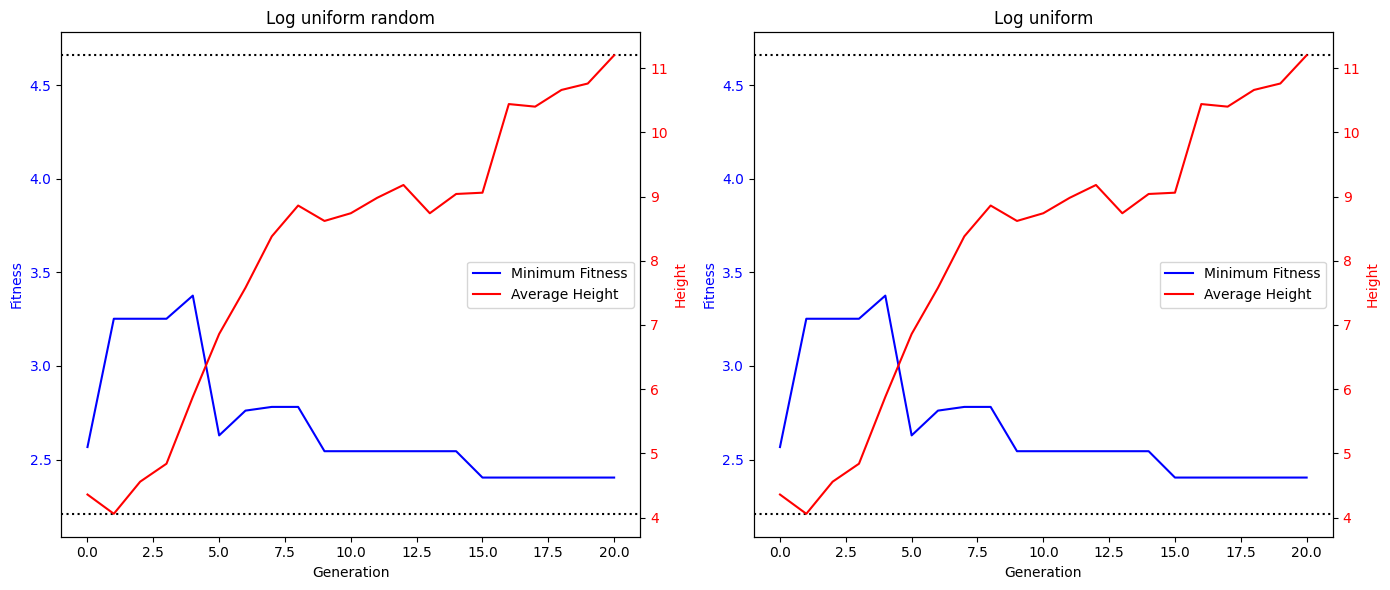

In [ ]:
# Create a new figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Plot the first log on the first subplot
plot_log(log_uni_r, ax1=axs[0])
axs[0].set_title("Log uniform")

# Plot the second log on the second subplot
plot_log(log_uni_r, ax1=axs[1])
axs[1].set_title("Log uniform random")

# Adjust layout and display the combined figure

plt.tight_layout()

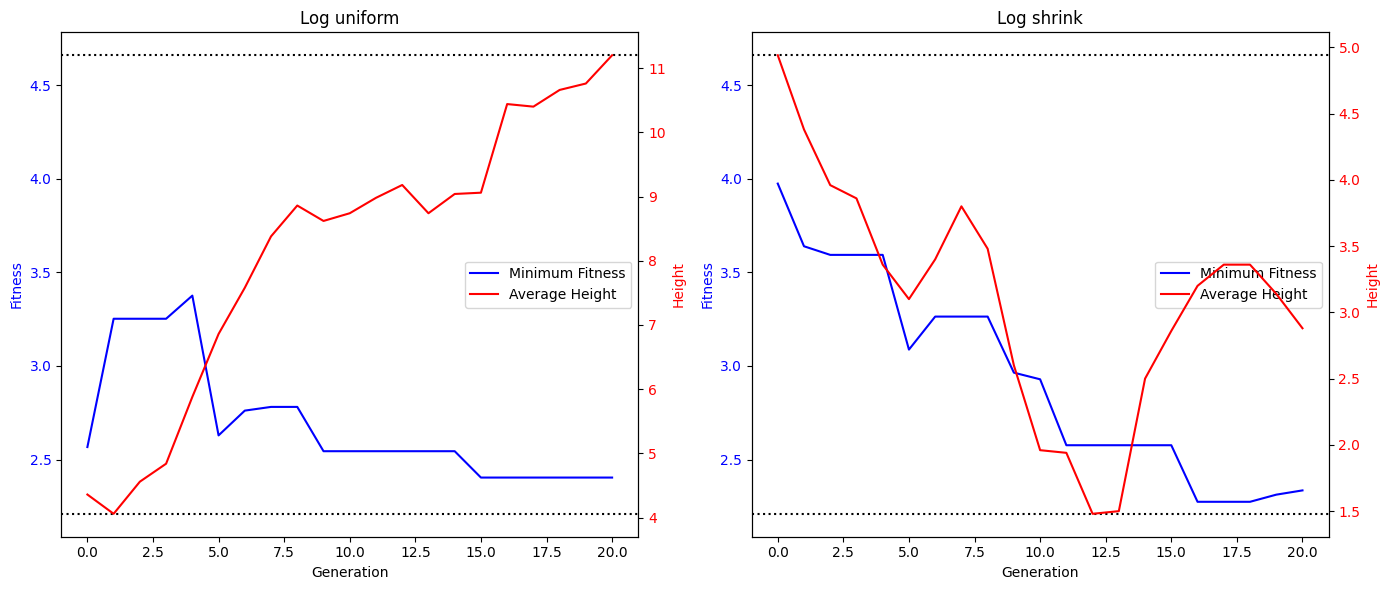

In [145]:
# Create a new figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Plot the first log on the first subplot
plot_log(log_uni_r, ax1=axs[0])
axs[0].set_title("Log uniform")

# Plot the second log on the second subplot
plot_log(log_sh_r, ax1=axs[1])
axs[1].set_title("Log shrink")

# Adjust layout and display the combined figure

plt.tight_layout()

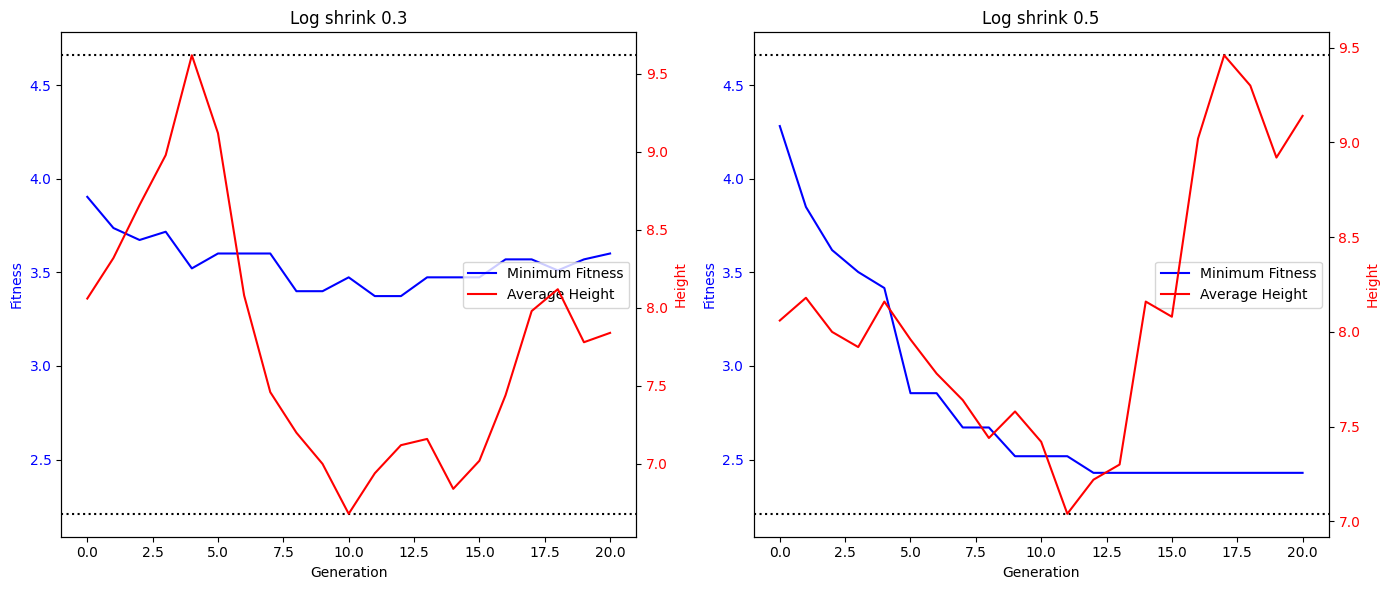

In [146]:
# Create a new figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Plot the first log on the first subplot
plot_log(log_sh_3, ax1=axs[0])
axs[0].set_title("Log shrink 0.3")

# Plot the second log on the second subplot
plot_log(log_sh_5, ax1=axs[1])
axs[1].set_title("Log shrink 0.5")

# Adjust layout and display the combined figure

plt.tight_layout()

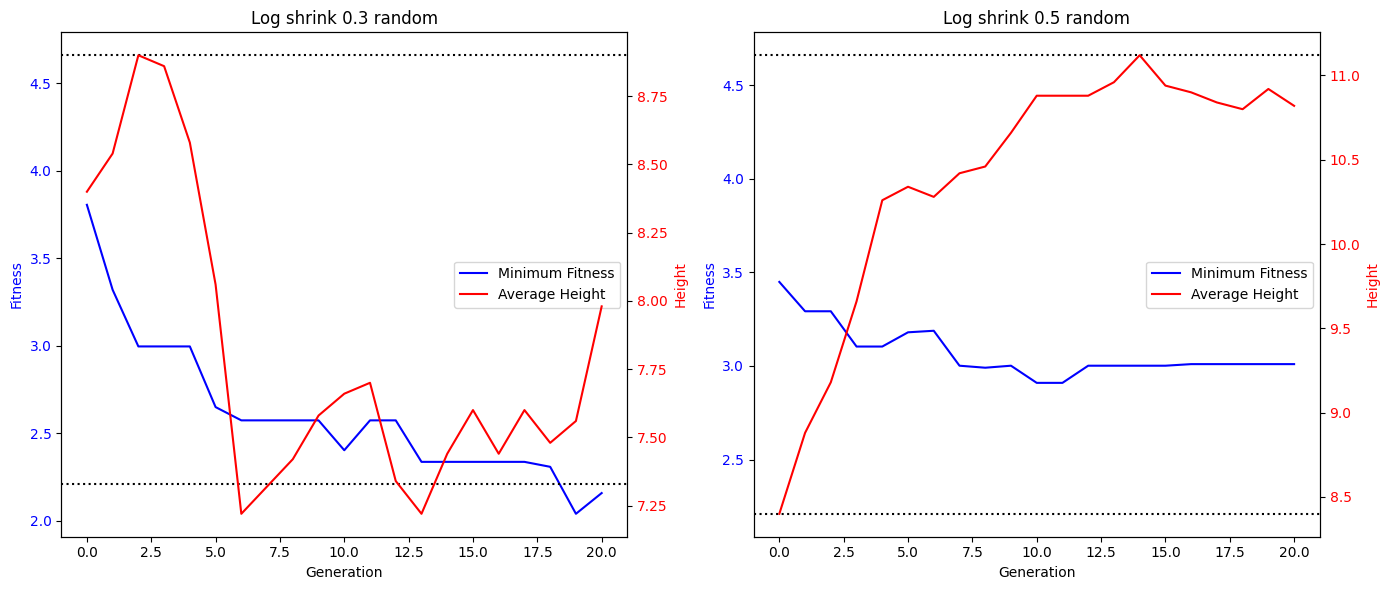

In [147]:
# Create a new figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Plot the first log on the first subplot
plot_log(log_sh_3r, ax1=axs[0])
axs[0].set_title("Log shrink 0.3 random")

# Plot the second log on the second subplot
plot_log(log_sh_5r, ax1=axs[1])
axs[1].set_title("Log shrink 0.5 random")

# Adjust layout and display the combined figure

plt.tight_layout()

### Hall of fame

In [149]:
hof_uni_r = [clean_rand(str(ind)) for ind in load_hof()]
hof_sh_r = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink.pkl')]
hof_sh_3r = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut03.pkl')]
hof_sh_5r = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut05.pkl')]
hof_sh_3 = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut03_norand.pkl')]
hof_sh_5 = [clean_rand(str(ind)) for ind in load_hof('logs/hof_shrink_mut05_norand.pkl')]

In [150]:
def clean_rand(expr):
    index_open = None
    
    for i in range(len(expr) - 8):
        if expr[i:i + 8] == 'gen_rand' and expr[i:i + 11] != 'gen_rand(0)':
            index_open = i
            break
    if index_open is None:
        return expr
    
    if index_open is not None:

        counter = 1
        for j in range(index_open + 9, len(expr)):
            if expr[j] == '(':
                counter += 1
            elif expr[j] == ')':
                counter -= 1
            
            if counter == 0:
                
                expr = expr[:index_open + 9] + '0' + expr[j:]
                break
        return clean_rand(expr)

    return expr

# string representation

In [92]:
operations = [
    'negative',
    'subtract',
    'multiply',
    'negate',
    'add',
]

In [93]:
expr = 'multiply(multiply(subtract(add(add(multiply(add(subtract(multiply(negative(negative(1.2061382054913272)), multiply(multiply(3.141592653589793, 2.792975412630669), negative(swarm))), subtract(subtract(multiply(1.3535018756499855, swarm), add(swarm, 1)), add(negative(1), multiply(center, gbest)))), negative(add(subtract(negative(dispersion), add(3.141592653589793, gbest)), negative(add(3.420888396619452, gbest))))), negative(add(multiply(multiply(add(4.546230784165469, 1), subtract(1.2863324133037861, dispersion)), add(negative(swarm), subtract(3.141592653589793, 1))), subtract(multiply(subtract(1, gbest), negative(3.141592653589793)), multiply(negative(center), subtract(swarm, 3.141592653589793)))))), add(multiply(add(add(subtract(multiply(3.141592653589793, 4.867982913485721), negative(1)), subtract(negative(3.141592653589793), negative(pbest))), negative(multiply(subtract(dispersion, 3.141592653589793), add(swarm, pbest)))), negative(negative(subtract(add(gbest, 3.865779421527601), negative(dispersion))))), subtract(add(multiply(negative(subtract(0.9117810978010121, 3.141592653589793)), subtract(negative(swarm), add(3.141592653589793, 1))), add(subtract(add(center, 3.141592653589793), add(gbest, pbest)), subtract(negative(3.141592653589793), add(3.141592653589793, gbest)))), negative(subtract(multiply(multiply(3.141592653589793, dispersion), multiply(2.1480037908235285, 3.898786075691051)), add(negative(vel), add(0.6306849011410331, 1))))))), add(add(multiply(multiply(subtract(subtract(subtract(2.9594382282107046, center), subtract(3.141592653589793, 1)), subtract(negative(2.2875709305324436), negative(1.960091850902674))), multiply(multiply(add(vel, pbest), add(4.168135108081047, swarm)), negative(add(0.8440895212388716, dispersion)))), add(subtract(multiply(multiply(dispersion, 3.649539204718388), multiply(1, 3.141592653589793)), subtract(subtract(3.141592653589793, pbest), add(1, swarm))), multiply(negative(multiply(vel, dispersion)), multiply(subtract(vel, gbest), subtract(dispersion, 3.141592653589793))))), add(negative(add(subtract(add(pbest, pbest), negative(3.141592653589793)), negative(subtract(3.8726259990413188, vel)))), add(add(subtract(add(4.891222005503547, 3.1188397983779885), negative(center)), subtract(add(pbest, 1), multiply(1.5875930653304997, center))), negative(subtract(multiply(3.141592653589793, center), multiply(4.96315112781103, 1)))))), negative(negative(add(add(negative(add(1, center)), negative(subtract(vel, pbest))), subtract(multiply(multiply(4.947735318630717, 3.81013802537399), subtract(1, 1)), multiply(negative(1), add(1.9886957956258815, 3.141592653589793)))))))), multiply(multiply(add(negative(negative(multiply(multiply(add(gbest, pbest), subtract(gbest, 1)), multiply(add(dispersion, center), subtract(gbest, 1))))), subtract(negative(negative(multiply(multiply(swarm, vel), add(swarm, swarm)))), subtract(add(multiply(negative(0.3488706273004333), add(pbest, pbest)), negative(multiply(1, pbest))), multiply(subtract(negative(1.6755814500064825), subtract(dispersion, center)), multiply(add(1, gbest), subtract(pbest, swarm)))))), add(multiply(multiply(subtract(multiply(subtract(1, swarm), add(4.697687523607856, center)), add(negative(center), subtract(dispersion, 1.1012160510907716))), negative(add(negative(0.7284371899355035), negative(2.449513409030617)))), subtract(negative(subtract(negative(1), add(dispersion, pbest))), subtract(add(add(swarm, center), add(swarm, 1.547079513370106)), add(multiply(vel, center), multiply(swarm, 3.141592653589793))))), add(subtract(negative(subtract(subtract(swarm, gbest), add(3.7044989180215304, 1))), add(subtract(subtract(3.141592653589793, swarm), subtract(swarm, 3.2571538668016933)), subtract(negative(gbest), negative(1)))), add(subtract(add(subtract(gbest, 3.141592653589793), multiply(4.746867677774674, 4.4124716094441725)), subtract(subtract(gbest, 1.9275867122325474), add(2.0590176411432184, gbest))), multiply(negative(multiply(3.141592653589793, swarm)), subtract(add(gbest, 1), multiply(dispersion, 0.5784340786940689))))))), multiply(negative(add(add(multiply(multiply(add(4.5687225958050774, swarm), subtract(vel, 2.5948628143618064)), add(multiply(gbest, 3.1039950298291936), multiply(1, 1.5963408883942116))), add(add(negative(3.141592653589793), add(dispersion, swarm)), add(subtract(vel, gbest), add(center, gbest)))), negative(add(multiply(multiply(pbest, gbest), negative(4.691390212366899)), add(add(3.570690305836232, 3.9361621886539306), add(pbest, center)))))), negative(negative(add(add(subtract(add(4.394315002721117, center), multiply(center, gbest)), multiply(add(center, 1.122853261679408), subtract(swarm, center))), subtract(add(multiply(vel, 1), multiply(gbest, swarm)), add(multiply(gbest, swarm), subtract(pbest, dispersion))))))))), add(negative(add(multiply(negative(negative(add(multiply(negative(center), add(4.922313189646266, 1)), subtract(subtract(swarm, 1.9922083408502456), add(1.5378556367200051, 4.662107875563425))))), negative(multiply(multiply(add(subtract(dispersion, 3.141592653589793), multiply(center, 3.141592653589793)), multiply(multiply(3.0413876277008702, swarm), negative(1))), add(negative(negative(pbest)), multiply(negative(vel), multiply(3.141592653589793, 3.141592653589793)))))), subtract(negative(subtract(negative(negative(negative(1))), negative(multiply(negative(2.1097322707409925), multiply(swarm, 4.6001442712698974))))), subtract(multiply(subtract(multiply(add(center, 4.99908610800761), add(0.3224860993788303, dispersion)), subtract(multiply(0.2701579732855519, pbest), multiply(2.575995404941348, 1))), negative(multiply(negative(3.9857629551265603), multiply(1, 0.6044039500847459)))), subtract(multiply(multiply(negative(pbest), multiply(4.530453391139108, vel)), subtract(subtract(pbest, 3.7945203139076753), subtract(1.3275245123142054, dispersion))), subtract(negative(add(dispersion, 1)), subtract(multiply(3.141592653589793, 4.483364438848042), subtract(gbest, center)))))))), multiply(add(add(add(add(subtract(subtract(subtract(2.7514070932985275, swarm), subtract(vel, 1)), subtract(multiply(swarm, swarm), multiply(gbest, gbest))), subtract(multiply(add(3.141592653589793, gbest), subtract(pbest, 0.45488804463832466)), negative(subtract(3.141592653589793, 1.0897868079565776)))), negative(multiply(subtract(multiply(swarm, 1), subtract(gbest, center)), subtract(multiply(dispersion, 0.8271796319794023), negative(dispersion))))), negative(add(negative(add(add(dispersion, 0.3973684845530673), add(1, 3.960434018581536))), subtract(subtract(subtract(center, swarm), negative(4.04865319917576)), subtract(add(vel, swarm), negative(center)))))), add(negative(subtract(add(add(add(3.141592653589793, gbest), add(swarm, 2.4405970173180584)), subtract(negative(gbest), subtract(dispersion, 3.141592653589793))), add(subtract(subtract(pbest, gbest), multiply(center, center)), negative(subtract(0.9258007995010331, 3.434582435432512))))), subtract(multiply(add(multiply(subtract(pbest, center), multiply(4.0754461106211455, pbest)), add(negative(swarm), subtract(2.4396754472515445, dispersion))), multiply(add(negative(pbest), multiply(swarm, center)), negative(multiply(pbest, 1.5273982709093143)))), multiply(negative(multiply(multiply(1.2639232818488084, 1.2760818355068715), negative(4.669112760737989))), add(add(multiply(pbest, dispersion), multiply(center, dispersion)), negative(subtract(dispersion, center))))))), negative(subtract(subtract(add(subtract(add(negative(1), negative(gbest)), negative(negative(vel))), negative(multiply(multiply(1, swarm), multiply(1, swarm)))), subtract(add(multiply(subtract(dispersion, 1.479284817125387), add(3.6738471008987075, 0.8640386709067627)), subtract(subtract(dispersion, 0.35136573225063195), subtract(dispersion, vel))), multiply(negative(negative(3.7973830938704767)), multiply(subtract(vel, gbest), add(1, 1))))), negative(subtract(add(add(negative(3.7664409359798663), negative(vel)), multiply(subtract(pbest, 3.5408966730252778), subtract(4.61764275214489, 2.8279558055960843))), subtract(subtract(subtract(0.4202708515333098, center), multiply(3.141592653589793, dispersion)), subtract(add(vel, gbest), multiply(2.1110606004821704, gbest)))))))))), negative(negative(add(negative(add(subtract(multiply(multiply(multiply(negative(vel), negative(pbest)), negative(subtract(center, center))), subtract(subtract(add(1.3468062365494482, dispersion), add(vel, dispersion)), subtract(add(swarm, gbest), add(gbest, dispersion)))), multiply(subtract(subtract(negative(dispersion), negative(swarm)), add(multiply(vel, swarm), add(dispersion, vel))), multiply(subtract(subtract(1, center), add(1, vel)), negative(subtract(swarm, 4.756204659805515))))), add(add(negative(add(subtract(1.6856633437357793, pbest), subtract(pbest, pbest))), negative(negative(add(pbest, swarm)))), negative(add(add(subtract(pbest, pbest), add(dispersion, vel)), multiply(multiply(3.474463246094275, swarm), negative(1))))))), negative(negative(negative(multiply(negative(subtract(multiply(dispersion, 1.80219060315008), multiply(pbest, pbest))), multiply(negative(negative(gbest)), add(negative(3.141592653589793), add(4.648141601845731, gbest)))))))))))'

In [94]:
'subtract(subtract(negative(multiply(subtract(1.2375081118745572, center), negative(add(subtract(dispersion, 0.5142041335443548), 3.719699770076712)))), negative(negative(subtract(1.1229994919240687 + 1 + gbest -vel), 3.141592653589793)))), -swarm * [ - 3.2178005605337567 * 3.141592653589793  - dispersion + center]))))'

'subtract(subtract(negative(multiply(subtract(1.2375081118745572, center), negative(add(subtract(dispersion, 0.5142041335443548), 3.719699770076712)))), negative(negative(subtract(1.1229994919240687 + 1 + gbest -vel), 3.141592653589793)))), -swarm * [ - 3.2178005605337567 * 3.141592653589793  - dispersion + center]))))'